<a href="https://colab.research.google.com/github/ramyamahesh1126/Deep-Learning/blob/Assignment4/Weights_%26_Biases_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# remove slow mirror from list of MNIST mirrors
torchvision.datasets.MNIST.mirrors = [mirror for mirror in torchvision.datasets.MNIST.mirrors
                                      if not mirror.startswith("http://yann.lecun.com")]

In [2]:
%%capture
!pip install wandb --upgrade

In [3]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
config = dict(
    epochs=5,
    classes=10,
    kernels=[16, 32],
    batch_size=128,
    learning_rate=0.005,
    dataset="MNIST",
    architecture="CNN")

In [5]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="pytorch-demo", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      train(model, train_loader, criterion, optimizer, config)

      # and test its final performance
      test(model, test_loader)

    return model

In [6]:
def make(config):
    # Make the data
    train, test = get_data(train=True), get_data(train=False)
    train_loader = make_loader(train, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)

    # Make the model
    model = ConvNet(config.kernels, config.classes).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, test_loader, criterion, optimizer

In [7]:
def get_data(slice=5, train=True):
    full_dataset = torchvision.datasets.MNIST(root=".",
                                              train=train, 
                                              transform=transforms.ToTensor(),
                                              download=True)
    #  equiv to slicing with [::slice] 
    sub_dataset = torch.utils.data.Subset(
      full_dataset, indices=range(0, len(full_dataset), slice))
    
    return sub_dataset


def make_loader(dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size, 
                                         shuffle=True,
                                         pin_memory=True, num_workers=2)
    return loader

In [8]:
# Conventional and convolutional neural network

class ConvNet(nn.Module):
    def __init__(self, kernels, classes=10):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * kernels[-1], classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
def train(model, loader, criterion, optimizer, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)


def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [10]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

In [11]:
def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {100 * correct / total}%")
        
        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

In [12]:
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)

wandb: Currently logged in as: ramyamahesh (use `wandb login --relogin` to force relogin)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


  0%|          | 0/5 [00:00<?, ?it/s]

Loss after 03072 examples: 0.529
Loss after 06272 examples: 0.184
Loss after 09472 examples: 0.194
Loss after 12640 examples: 0.115
Loss after 15840 examples: 0.077
Loss after 19040 examples: 0.078
Loss after 22240 examples: 0.054
Loss after 25408 examples: 0.099
Loss after 28608 examples: 0.059
Loss after 31808 examples: 0.058
Loss after 35008 examples: 0.147
Loss after 38176 examples: 0.032
Loss after 41376 examples: 0.014
Loss after 44576 examples: 0.004
Loss after 47776 examples: 0.081
Loss after 50944 examples: 0.018
Loss after 54144 examples: 0.035
Loss after 57344 examples: 0.032
Accuracy of the model on the 2000 test images: 98.1%



epoch,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆███
loss,█▃▄▂▂▂▂▂▂▂▃▁▁▁▂▁▁▁
test_accuracy,▁
epoch,4
loss,0.03249
test_accuracy,0.981


### Visualizations

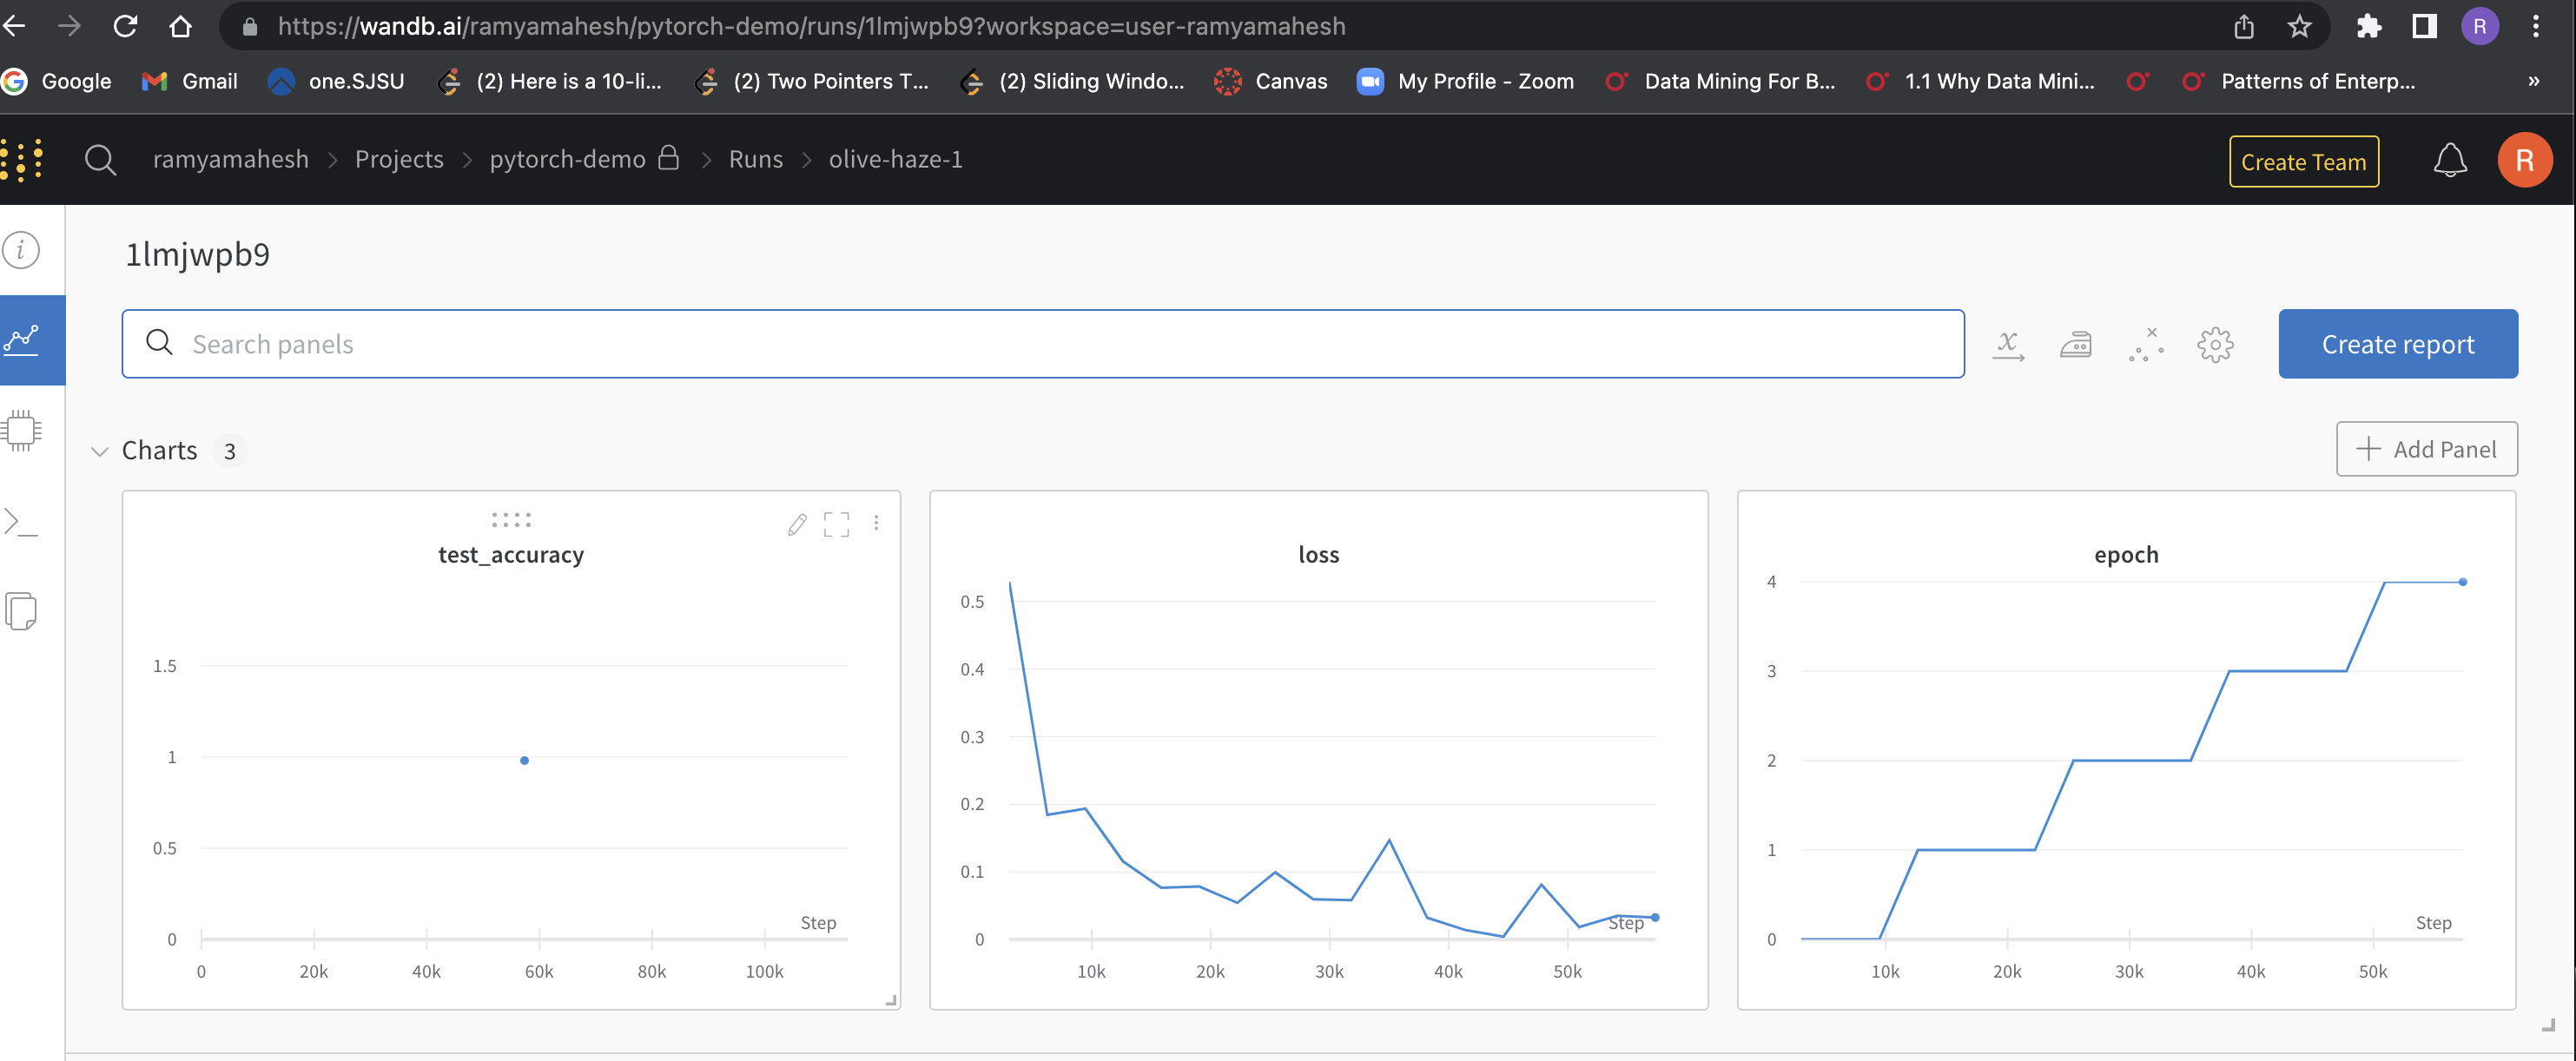